<a href="https://colab.research.google.com/github/maddalayasaswini/FMML_Lab_Modules/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-17 15:46:31--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.41, 18.239.225.61, 18.239.225.55, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  22.6MB/s    in 2.0s    

2024-05-17 15:46:34 (22.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


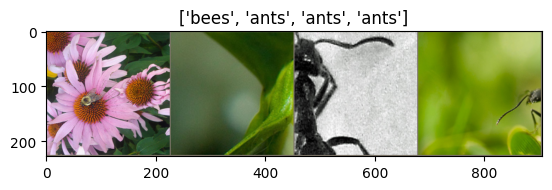

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5961 Acc: 0.6967

Epoch 1/4
----------
Loss: 0.5585 Acc: 0.7828

Epoch 2/4
----------
Loss: 0.3877 Acc: 0.8484

Epoch 3/4
----------
Loss: 0.4439 Acc: 0.8115

Epoch 4/4
----------
Loss: 0.4411 Acc: 0.8361



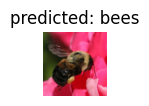

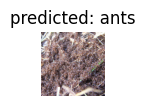

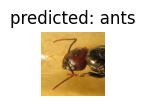

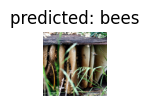

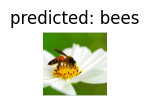

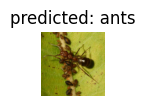

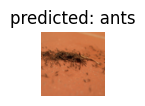

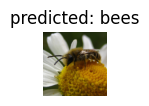

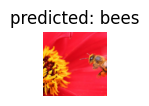

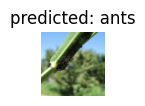

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWER 1

The significance of using data augmentations like resize, crop, and other transformations on training data in machine learning, particularly in training Convolutional Neural Networks (CNNs), includes several key benefits:

*Increased Training Data Variety:*

Explanation: Data augmentation techniques create new, slightly modified versions of the training data by applying transformations such as resizing, cropping, flipping, rotating, and more. This effectively increases the size and diversity of the training dataset without requiring the collection of new data.
Benefit: This helps the model generalize better to new, unseen data by learning from a more varied set of examples.

*Improved Generalization:*

Explanation: By exposing the model to various transformations of the input data, data augmentation helps the model become more robust to variations in the input data, such as changes in scale, orientation, and position.
Benefit: This reduces the likelihood of overfitting, where the model performs well on the training data but poorly on new data.

*Reduced Overfitting:*

Explanation: Overfitting occurs when a model learns to memorize the training data rather than learning the underlying patterns. Data augmentation introduces variations in the training data, which makes it harder for the model to memorize specific examples.
Benefit: This encourages the model to learn more general features that are applicable to new data.

*Better Model Performance:*

Explanation: Augmented data provides more training examples, allowing the model to learn more effectively and improve its performance on the validation and test datasets.
Benefit: This can lead to better accuracy, precision, recall, and other performance metrics.

*Simulating Real-World Variations:*

Explanation: Real-world data often contains various forms of noise and distortions. Data augmentation can simulate these variations, such as changes in lighting conditions, occlusions, and background clutter.
Benefit: Training on augmented data helps the model handle similar variations when deployed in real-world scenarios.

*Increased Robustness to Small Changes:*

Explanation: Augmentations like cropping, rotating, and flipping teach the model to recognize objects and patterns despite small changes in the input data.
Benefit: This makes the model more robust to minor alterations in the input images, improving its overall reliability.

ANSWER 2


Longer Training Time:

Training a ResNet model from scratch requires a longer training time because the model starts with randomly initialized weights. It needs to learn all the features from the data from scratch.
Need for More Data:

Training from scratch generally requires a large amount of labeled data. Pretrained models benefit from transfer learning, leveraging knowledge from a large dataset like ImageNet. Without this, the model may not perform well if the training dataset is small.
Lower Initial Performance:

Initially, the performance (accuracy, loss) will likely be lower compared to a pretrained model. Pretrained models start with weights that already encode useful features learned from a large and diverse dataset.
Risk of Overfitting:

If the training dataset is not large enough, the model trained from scratch is more likely to overfit, meaning it will perform well on the training data but poorly on the validation/test data.
Potential for Higher Performance on Specific Tasks:

While starting from scratch might be less efficient and initially less performant, it offers the potential to achieve higher performance on very specific tasks or datasets where the features learned from a pretrained model might not be optimal.
Practical Example
If you change pretrained=False and train a ResNet model on a dataset like CIFAR-10 or a smaller custom dataset, you might observe:

Initial Training Accuracy: Lower, because the model starts without any prior knowledge.
Validation Accuracy: Likely lower initially and may require more epochs to reach comparable performance to a pretrained model.
Training Time: Significantly longer due to the need to learn all features from scratch.
Performance Metrics Comparison
Pretrained ResNet: Quickly converges to high accuracy, often requiring fewer epochs to achieve good performance. It benefits from features learned from large datasets like ImageNet.
ResNet from Scratch: Slower convergence, potentially lower accuracy depending on the size and quality of the training data. It may take many more epochs and fine-tuning to achieve comparable performance.

ANSWER 3


Advantages of Using a Pretrained Model
Transfer Learning:

Even if the source dataset is quite different, the lower layers of a pretrained model often learn generic features (e.g., edges, textures) that can be useful for a wide range of tasks. These features can still provide a good starting point.
Faster Convergence:

Starting with pretrained weights can lead to faster convergence during training compared to training from scratch. This is because the model already has some useful feature representations.
Reduced Need for Large Data:

Using a pretrained model reduces the need for a large labeled dataset. The pretrained weights can help in achieving better performance even with a smaller dataset, like the ants vs. bees dataset.
Challenges and Considerations
Dataset Differences:

If the source dataset is significantly different (e.g., medical images vs. natural images), the higher-level features learned by the pretrained model might not be as relevant. This could lead to suboptimal performance.
Fine-Tuning:

Fine-tuning the pretrained model on the new dataset can help mitigate differences. Fine-tuning involves training the model on the new dataset for a few epochs, allowing it to adjust the weights to better fit the new data.
Layer Freezing:

One approach is to freeze the initial layers of the pretrained model and only train the higher layers (or add new layers) on the new dataset. This way, the model retains the generic features learned from the original dataset and adapts higher-level features to the new dataset.
